In [30]:
import trackhhl.toy.simple_generator as toy
import trackhhl.event_model.q_event_model as em
import numpy as np
import itertools
import copy
from dwave.samplers import SimulatedAnnealingSampler, TabuSampler
import dimod
import psutil
import time
from scipy.sparse import lil_matrix, csc_matrix, block_diag
from dwave.system import DWaveSampler, EmbeddingComposite
import tracemalloc




In [31]:
N_MODULES = 3
LX = float("+inf")
LY = float("+inf")
Z_SPACING = 1.0

detector = toy.SimpleDetectorGeometry(
    module_id=list(range(N_MODULES)),
    lx=[LX] * N_MODULES,
    ly=[LY] * N_MODULES,
    z=[i + Z_SPACING for i in range(N_MODULES)]
)

generator = toy.SimpleGenerator(
    detector_geometry=detector,
    theta_max=np.pi / 6
)

N_PARTICLES = 2
event = generator.generate_event(N_PARTICLES)
event.hits

[Hit(hit_id=0, x=0.1439352460617089, y=-0.0442483134079846, z=1.0, module_id=0, track_id=0),
 Hit(hit_id=3, x=0.2455986424095578, y=0.21095782018360423, z=1.0, module_id=0, track_id=1),
 Hit(hit_id=1, x=0.2878704921234178, y=-0.0884966268159692, z=2.0, module_id=1, track_id=0),
 Hit(hit_id=4, x=0.4911972848191156, y=0.42191564036720847, z=2.0, module_id=1, track_id=1),
 Hit(hit_id=2, x=0.43180573818512674, y=-0.1327449402239538, z=3.0, module_id=2, track_id=0),
 Hit(hit_id=5, x=0.7367959272286734, y=0.6328734605508127, z=3.0, module_id=2, track_id=1)]

In [32]:
def generate_detector_hits(n_modules, n_particles):
    LX = float("+inf")
    LY = float("+inf")
    Z_SPACING = 1.0
    THETA_MAX = np.pi / 6

    # Create detector geometry with fixed lx, ly, and z_spacing
    detector = toy.SimpleDetectorGeometry(
        module_id=list(range(n_modules)),
        lx=[LX] * n_modules,
        ly=[LY] * n_modules,
        z=[i + Z_SPACING for i in range(n_modules)]  # Match original behavior by using i + Z_SPACING
    )

    # Create a generator for particles
    generator = toy.SimpleGenerator(
        detector_geometry=detector,
        theta_max=THETA_MAX
    )

    # Generate an event with the specified number of particles
    event = generator.generate_event(n_particles)

    # Return the hits generated by the event
    return event

In [33]:
params = {
    'alpha': 1.0,
    'beta': 1.0,
    'lambda': 100.0,} 

def generate_hamiltonian_optimized(event, params):
    lambda_val = params.get('lambda')
    alpha = params.get('alpha')
    beta = params.get('beta')

    modules = sorted(event.modules, key=lambda module: module.z)

    
    segments = [
        em.segment(from_hit, to_hit)
        for idx in range(len(modules) - 1)
        for from_hit, to_hit in itertools.product(modules[idx].hits, modules[idx + 1].hits)
    ]

    N = len(segments)  

    #initialize sparse block matrices for effviciency
    A_ang_blocks = []
    A_bif_blocks = []
    A_inh_blocks = []
    b = np.zeros(N)

    #total Hamiltonian into smaller blocks->> better for memory
    block_size = 500  
    num_blocks = (N + block_size - 1) // block_size  

    for block_idx in range(num_blocks):
        start_idx = block_idx * block_size
        end_idx = min(start_idx + block_size, N)

        #lil_matrix for each block
        A_ang_block = lil_matrix((end_idx - start_idx, end_idx - start_idx), dtype=np.float32)
        A_bif_block = lil_matrix((end_idx - start_idx, end_idx - start_idx), dtype=np.float32)
        A_inh_block = lil_matrix((end_idx - start_idx, end_idx - start_idx), dtype=np.float32)

        #filling of papricas
        for i in range(start_idx, end_idx):
            seg_i = segments[i]
            vect_i = seg_i.to_vect()
            norm_i = np.linalg.norm(vect_i)

            for j in range(i + 1, end_idx):  #
                seg_j = segments[j]
                vect_j = seg_j.to_vect()
                norm_j = np.linalg.norm(vect_j)

                cosine = np.dot(vect_i, vect_j) / (norm_i * norm_j)
                if np.abs(cosine - 1) < 1e-9:
                    A_ang_block[i - start_idx, j - start_idx] = 1
                    A_ang_block[j - start_idx, i - start_idx] = 1  # Symmetry with positive sign

                if seg_i.from_hit == seg_j.from_hit and seg_i.to_hit != seg_j.to_hit:
                    A_bif_block[i - start_idx, j - start_idx] = -alpha
                    A_bif_block[j - start_idx, i - start_idx] = -alpha  # Symmetry with negative sign

                if seg_i.from_hit != seg_j.from_hit and seg_i.to_hit == seg_j.to_hit:
                    A_bif_block[i - start_idx, j - start_idx] = -alpha
                    A_bif_block[j - start_idx, i - start_idx] = -alpha  # Symmetry with negative sign

                s_ab = int(seg_i.from_hit.module_id == 1 and seg_j.to_hit.module_id == 1)
                if s_ab > 0:
                    A_inh_block[i - start_idx, j - start_idx] = beta * s_ab * s_ab
                    A_inh_block[j - start_idx, i - start_idx] = beta * s_ab * s_ab  # Symmetry with positive sign

        A_ang_blocks.append(A_ang_block)
        A_bif_blocks.append(A_bif_block)
        A_inh_blocks.append(A_inh_block)

    # combine withblock diagonal
    A_ang = block_diag(A_ang_blocks, format='csc')
    A_bif = block_diag(A_bif_blocks, format='csc')
    A_inh = block_diag(A_inh_blocks, format='csc')

    A = -1 * (A_ang + A_bif + A_inh)
    true_solution = np.array([1 if segment.truth else 0 for segment in segments])

    return A, b, segments, true_solution

#performance measurement
#process = psutil.Process()

#start_memory = process.memory_info().rss / (1024 ** 2)  # Memory in MB
#start_time = time.time()

A, b, segments, true_solution = generate_hamiltonian_optimized(event, params)
#end_memory = process.memory_info().rss / (1024 ** 2)  # Memory in MB
#end_time = time.time()

#memory_used = end_memory - start_memory
#time_taken = end_time - start_time
#print(A.toarray())
#print(f"Memory used: {memory_used:.2f} MB")
#print(f"Time taken: {time_taken:.6f} seconds")
#print(true_solution)

In [34]:
import dimod
import psutil
import time
from scipy.sparse import csc_matrix

def qubosolver(A, b):


    #Keep A sparse
    A = csc_matrix(A)

    bqm = dimod.BinaryQuadraticModel.empty(dimod.BINARY)

    #vectors for efficiency 
    bqm.add_variables_from({i: b[i] for i in range(len(b))})

    row, col = A.nonzero()  
    for i, j in zip(row, col):
        if i != j:  
            bqm.add_interaction(i, j, A[i, j])

    sampler = SimulatedAnnealingSampler()
    response = sampler.sample(bqm, num_reads=100)

    best_sample = response.first.sample
    sol_sample = np.fromiter(best_sample.values(), dtype=int)  


    print(f"Solution:{sol_sample}")


    return sol_sample

#qubosolver(A, b)


In [35]:
import dimod
def qubosolverTABU(A, b):
    # Keep A sparse
    A = csc_matrix(A)
    bqm = dimod.BinaryQuadraticModel.empty(dimod.BINARY)

    # Vectors for efficiency 
    bqm.add_variables_from({i: b[i] for i in range(len(b))})

    row, col = A.nonzero()  
    for i, j in zip(row, col):
        if i != j:  
            bqm.add_interaction(i, j, A[i, j])

    sampler = TabuSampler()
    response = sampler.sample(bqm, num_reads=50)


    best_sample = response.first.sample
    sol_sample = np.fromiter(best_sample.values(), dtype=int)  
    print(sol_sample)

    return sol_sample

qubosolverTABU(A, b)

[1 0 0 1 1 0 0 1]


array([1, 0, 0, 1, 1, 0, 0, 1])

In [36]:
def qubosolverQA(A, b):
    # Start tracing memory allocations
    tracemalloc.start()
    start_time = time.time()

    # Keep A sparse
    A = csc_matrix(A)

    bqm = dimod.BinaryQuadraticModel.empty(dimod.BINARY)
    bqm.add_variables_from({i: b[i] for i in range(len(b))})

    row, col = A.nonzero()
    for i, j in zip(row, col):
        if i != j:
            bqm.add_interaction(i, j, A[i, j])

    # Use D-Wave's quantum sampler
    sampler = EmbeddingComposite(DWaveSampler(token='DEV-66ad440bb66cef7707c37ac3541b492c1b58203a'))
    response = sampler.sample(bqm, num_reads=100)

    best_sample = response.first.sample
    sol_sample = np.fromiter(best_sample.values(), dtype=int)

    end_time = time.time()
    # Get the current and peak memory usage
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    memory_used = peak / (1024 ** 2)
    time_taken = end_time - start_time

    print(f"Solution: {sol_sample}")
    print(f"Peak Memory Used: {memory_used:.2f} MB")
    print(f"Time Taken: {time_taken:.6f} seconds")

    return sol_sample, memory_used, time_taken

qubosolverQA(A, b)

Solution: [1 0 0 1 1 0 0 1]
Peak Memory Used: 47.83 MB
Time Taken: 8.878731 seconds


(array([1, 0, 0, 1, 1, 0, 0, 1]), 47.83281993865967, 8.87873125076294)

In [37]:
from dwave.system import LeapHybridSampler
import os

os.environ['DWAVE_API_TOKEN'] = 'DEV-66ad440bb66cef7707c37ac3541b492c1b58203a'
import tracemalloc
import time
import numpy as np
from scipy.sparse import csc_matrix
from dimod import BinaryQuadraticModel

# Rewritten classical QUBO solver to use the Leap Hybrid Solver
def qubosolverHr(A, b):
   
    # Keep A sparse
    A = csc_matrix(A)

    # Define a Binary Quadratic Model (BQM) for the QUBO problem
    bqm = BinaryQuadraticModel.empty(dimod.BINARY)

    # Add the linear terms from vector b
    bqm.add_variables_from({i: b[i] for i in range(len(b))})

    # Add the quadratic terms (interaction terms) from matrix A
    row, col = A.nonzero()  # Get non-zero entries in the matrix A
    for i, j in zip(row, col):
        if i != j:  # Only consider off-diagonal terms (interactions)
            bqm.add_interaction(i, j, A[i, j])

    # Use D-Wave's Leap Hybrid Solver, which handles large-scale problems
    sampler = LeapHybridSampler()

    # Solve the QUBO problem using the hybrid solver
    response = sampler.sample(bqm)

    # Extract the best sample (solution) from the response
    best_sample = response.first.sample
    sol_sample = np.fromiter(best_sample.values(), dtype=int)

    # Output solution and performance details
    print(f"Solution: {sol_sample}")
    return sol_sample
qubosolverHr(A, b)

Solution: [1 0 0 1 1 0 0 1]


array([1, 0, 0, 1, 1, 0, 0, 1])

In [41]:
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, matthews_corrcoef, jaccard_score
import matplotlib.pyplot as plt
from scipy.sparse import csc_matrix, block_diag, lil_matrix
import itertools

def compare_solvers(A, b, true_solution, solvers):
    """
    Compares multiple QUBO solvers on a given problem defined by matrix A, vector b, and true_solution.
    
    Parameters:
    - A (csc_matrix): The matrix defining the QUBO problem in CSC format.
    - b (np.array): The vector defining the QUBO problem.
    - true_solution (np.array): The correct solution for the QUBO problem.
    - solvers (list): List of solver functions to compare.
    
    Returns:
    - DataFrame with solver names and their corresponding accuracy metrics.
    """
    results = {
        "solver": [],
        "f1_score": [],
        "mcc": [],
        "jaccard": []
    }

    # Run each solver and calculate metrics
    for solver_func in solvers:
        solver_name = solver_func.__name__

        try:
            # Run solver with A in sparse format
            estimated_solution = solver_func(A, b)

            # Calculate metrics
            f1 = f1_score(true_solution, estimated_solution, zero_division=1)
            mcc = matthews_corrcoef(true_solution, estimated_solution)
            jaccard = jaccard_score(true_solution, estimated_solution, zero_division=1)

            # Store results
            results["solver"].append(solver_name)
            results["f1_score"].append(f1)
            results["mcc"].append(mcc)
            results["jaccard"].append(jaccard)

        except Exception as e:
            print(f"Error with solver '{solver_name}': {e}")
            results["solver"].append(solver_name)
            results["f1_score"].append(None)
            results["mcc"].append(None)
            results["jaccard"].append(None)

    return pd.DataFrame(results)

def test_solvers_for_particle_list(particle_counts, solvers, params):
    """
    Tests multiple QUBO solvers for a list of particle counts with a fixed detector geometry.
    """
    all_results = []
    N_MODULES = 3
    LX = float("+inf")
    LY = float("+inf")
    Z_SPACING = 1.0

    detector = toy.SimpleDetectorGeometry(
        module_id=list(range(N_MODULES)),
        lx=[LX] * N_MODULES,
        ly=[LY] * N_MODULES,
        z=[i + Z_SPACING for i in range(N_MODULES)]
    )
    
    generator = toy.SimpleGenerator(
        detector_geometry=detector,
        theta_max=np.pi / 6
    )

    for num_particles in particle_counts:
        print(f"\nTesting problem with {num_particles} particles")

        event = generator.generate_event(num_particles)
        A, b, segments, true_solution = generate_hamiltonian_optimized(event, params)
        
        results_df = compare_solvers(A, b, true_solution, solvers)
        results_df["num_particles"] = num_particles
        all_results.append(results_df)
    
    combined_results = pd.concat(all_results, ignore_index=True)
    return combined_results

def plot_metrics_vs_particles(results_df):
    """
    Plots the number of particles vs accuracy metrics for each solver.
    
    Parameters:
    - results_df (DataFrame): DataFrame containing solver results for various particle counts.
    """
    metrics = ["f1_score", "mcc", "jaccard"]
    titles = ["F1 Score", "Matthews Correlation Coefficient (MCC)", "Jaccard Similarity"]

    fig, axs = plt.subplots(3, 1, figsize=(10, 18))
    
    for i, metric in enumerate(metrics):
        for solver in results_df["solver"].unique():
            solver_df = results_df[results_df["solver"] == solver]
            axs[i].plot(solver_df["num_particles"], solver_df[metric], marker='o', label=solver)
        
        axs[i].set_title(titles[i], fontsize=14, weight='bold')
        axs[i].set_xlabel("Number of Particles", fontsize=12)
        axs[i].set_ylabel(metric.replace("_", " ").title(), fontsize=12)
        axs[i].legend()
        axs[i].grid(True)

    plt.tight_layout()
    plt.show()


solvers = [qubosolverHr, qubosolverTABU]
particle_counts = [5, 10, 20, 30, 40 , 50, 60, 70, 80, 90, 100]
params = {'alpha': 1.0, 'beta': 1.0, 'lambda': 100.0}
results_df = test_solvers_for_particle_list(particle_counts, solvers, params)
print(results_df)



Testing problem with 5 particles
Solution: [1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0
 1 0 0 0 0 0 1 0 0 0 0 0 1]
[1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0
 1 0 0 0 0 0 1 0 0 0 0 0 1]

Testing problem with 10 particles
Solution: [1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1]
[1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 

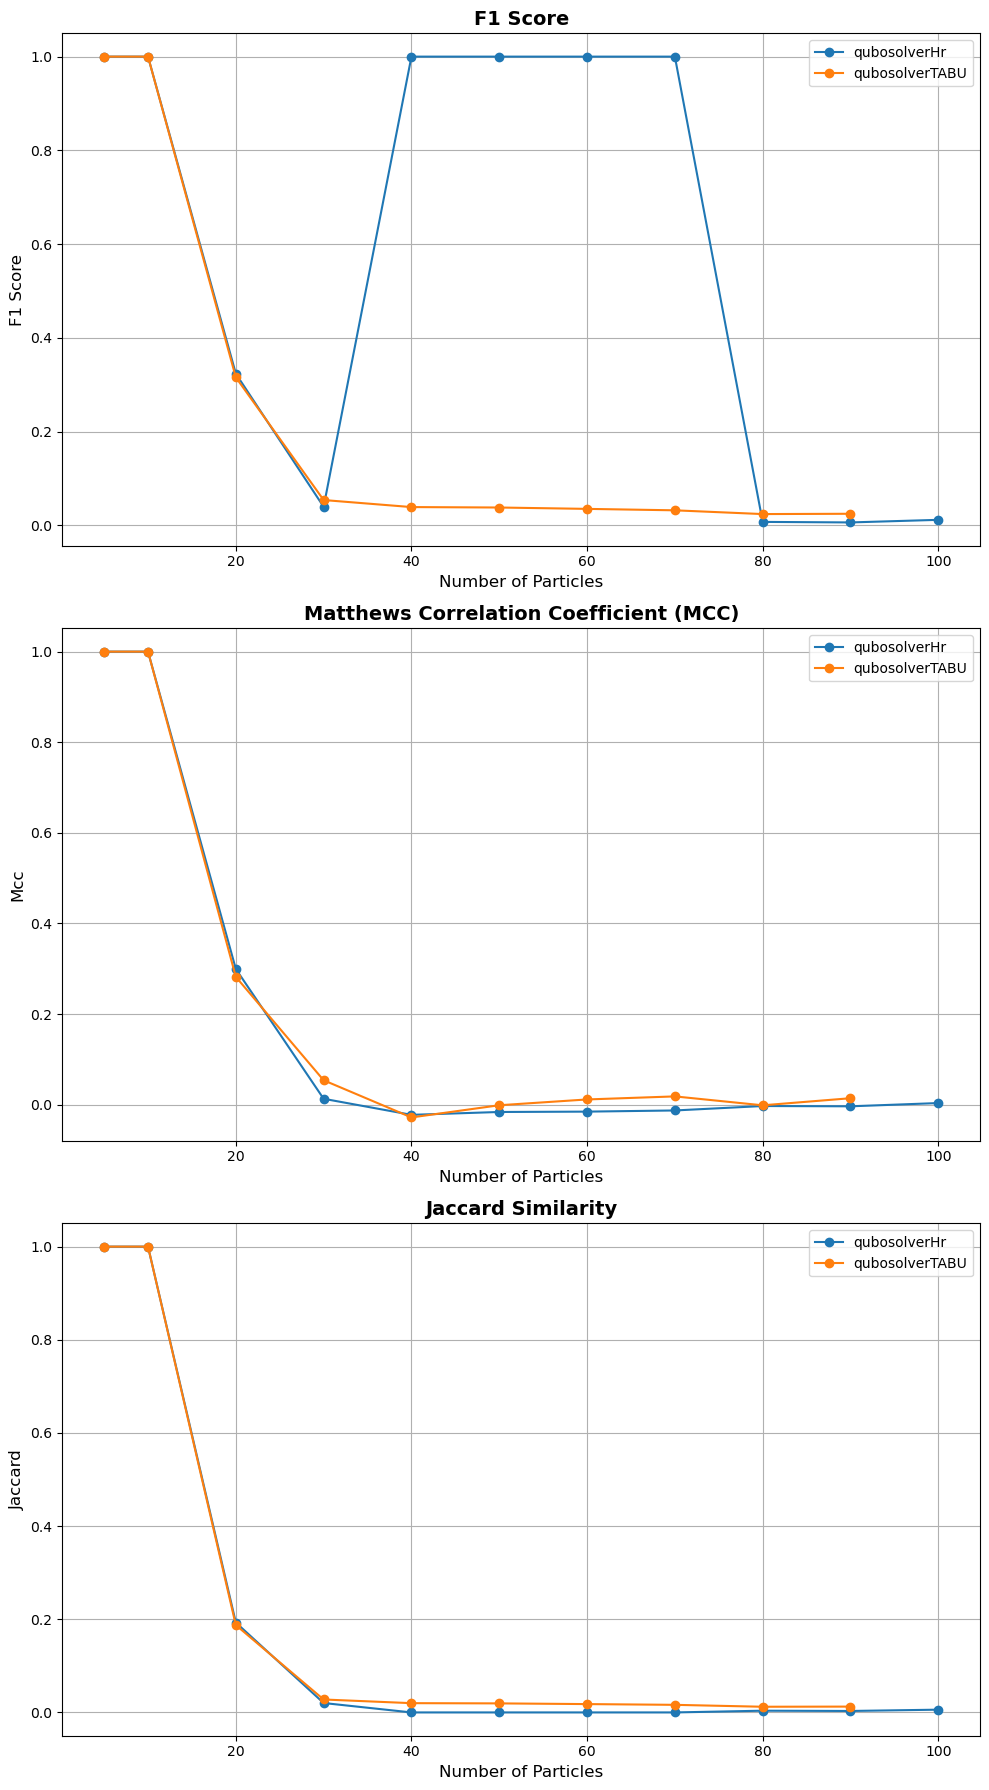

In [42]:
plot_metrics_vs_particles(results_df)

In [39]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def generate_detector_hits(n_modules, n_particles):
    LX = float("+inf")
    LY = float("+inf")
    Z_SPACING = 1.0
    THETA_MAX = np.pi / 6

    # Create detector geometry with fixed lx, ly, and z_spacing
    detector = toy.SimpleDetectorGeometry(
        module_id=list(range(n_modules)),
        lx=[LX] * n_modules,
        ly=[LY] * n_modules,
        z=[i + Z_SPACING for i in range(n_modules)]  # Match original behavior by using i + Z_SPACING
    )

    # Create a generator for particles
    generator = toy.SimpleGenerator(
        detector_geometry=detector,
        theta_max=THETA_MAX
    )

    # Generate an event with the specified number of particles
    event = generator.generate_event(n_particles)

    # Return the hits generated by the event
    return event.hits

# Assume the following functions are already defined:
# - generate_detector_hits(n_modules, n_particles)
# - generate_hamiltonian_optimized(event, params)
# - qubosolver(A, b)
# - qubosolverQA(A, b)
# - qubosolverHr(A, b)
# - qubosolverTABU(A, b) 

#Ns = [50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
Ns=[2,4,6]

# Initialize lists to store results
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
specificity_scores = []

for N in Ns:
    # Generate a random sparse symmetric matrix A with density 1%
   event.hits = generate_detector_hits(5, N)
   generate_hamiltonian_optimized(event, params)


    # Generate a random vector b
    b = np.random.randn(N)

    # Solve the QUBO problem using each solver
    x1 = qubosolverHr(A, b)
    x2 = qubosolverTABU(A, b)

    # Convert solutions to NumPy arrays
    x1 = np.array(x1)
    x2 = np.array(x2)

    # Compute metrics against true solution
    accuracy_1 = accuracy_score(x_true, x1)
    precision_1 = precision_score(x_true, x1)
    recall_1 = recall_score(x_true, x1)
    f1_1 = f1_score(x_true, x1)
    
    # Specificity calculation using confusion matrix
    tn, fp, fn, tp = confusion_matrix(x_true, x1).ravel()
    specificity_1 = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    # Store results for Hybrid solver
    accuracy_scores.append([accuracy_1])
    precision_scores.append([precision_1])
    recall_scores.append([recall_1])
    f1_scores.append([f1_1])
    specificity_scores.append([specificity_1])

# Convert results to NumPy arrays for easier plotting
accuracy_scores = np.array(accuracy_scores)
precision_scores = np.array(precision_scores)
recall_scores = np.array(recall_scores)
f1_scores = np.array(f1_scores)
specificity_scores = np.array(specificity_scores)

# Plot Accuracy
plt.figure(figsize=(10, 6))
plt.plot(Ns, accuracy_scores[:, 0], label='Hybrid', marker='o', linestyle='-', linewidth=2, markersize=8)
plt.xlabel('Matrix size')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Matrix size')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Precision
plt.figure(figsize=(10, 6))
plt.plot(Ns, precision_scores[:, 0], label='Hybrid', marker='o', linestyle='-', linewidth=2, markersize=8)
plt.xlabel('Matrix size')
plt.ylabel('Precision')
plt.title('Precision vs Matrix size')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Recall
plt.figure(figsize=(10, 6))
plt.plot(Ns, recall_scores[:, 0], label='Hybrid', marker='o', linestyle='-', linewidth=2, markersize=8)
plt.xlabel('Matrix size')
plt.ylabel('Recall')
plt.title('Recall vs Matrix size')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot F1 Score
plt.figure(figsize=(10, 6))
plt.plot(Ns, f1_scores[:, 0], label='Hybrid', marker='o', linestyle='-', linewidth=2, markersize=8)
plt.xlabel('Matrix size')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Matrix size')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Specificity
plt.figure(figsize=(10, 6))
plt.plot(Ns, specificity_scores[:, 0], label='Hybrid', marker='o', linestyle='-', linewidth=2, markersize=8)
plt.xlabel('Matrix size')
plt.ylabel('Specificity')
plt.title('Specificity vs Matrix size')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


IndentationError: unexpected indent (318726933.py, line 57)

In [23]:
from itertools import product
from scipy.sparse import csc_matrix

def brute_force(A, b):
    A = csc_matrix(A)
    n = len(b) 

    best_solution = None
    best_energy = np.inf
    for config in product([0, 1], repeat=n):
        config = np.array(config)
        
        #calculate energy: E = x^T A x + b^T x
        energy = config @ A @ config + b @ config
        if energy < best_energy:
            best_energy = energy
            best_solution = config

    print(f"Best Solution: {best_solution}")
    print(f"Best Energy: {best_energy}")

    return best_solution


brute_force_solution = brute_force(A, b)
print(f"Brute Force Solution: {brute_force_solution}")




Best Solution: [1 0 0 1 1 0 0 1]
Best Energy: -4.0
Brute Force Solution: [1 0 0 1 1 0 0 1]
